Дальнейшие идеи:
- разбить published_at и created_at по месяцам/кварталам, а не удалять
- попробовать убрать is_open, слишком не сбалансирован, вряд ли влияет на результат
- Подумать, как обработать employer
- Надо теперь подумать как заполнять пропуски в key_skills, достовать как-то инфу из других текстовых колонок snippet, description, specialization
- Пункт 7 - это One-hot кодирование? Если нет, то попробовать его

In [1103]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split

In [1104]:
# библиотека для работы с датасетами на kaggle
!pip install opendatasets --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [1105]:
import opendatasets as od
import pandas as pd

url = 'https://www.kaggle.com/competitions/yadro-regression-2025'
od.download(url)

# "username":"hope1133",
# "key":"69cbb4326c210d3db064b4bc090506c4"


Skipping, found downloaded files in "./yadro-regression-2025" (use force=True to force download)


In [1106]:
path = './yadro-regression-2025'
print(os.listdir(path))

['for_prediction.csv', 'train_contest.csv', 'Sample_Submission.csv']


Набор данных представлен в формате .csv. Обращаем Ваше внимание на то, что предлагаемые данные достаточно "грязные", и вам в полном объеме предоставляется творческая свобода для их предварительной обработки (разного рода преобразования, генерация новых признаков из имеющихся, и так далее).  

Целевой переменной является значение заработной платы (колонка mean_salary). Примечание: в качестве заработной платы обычно указывается некоторый диапазон (от и до). В рассматриваемом файле в качестве значения ЗП (колонка mean_salary) использовано среднее значение такого диапазона.  


train_contest.csv - тренировочный набор данных  
for_prediction.csv - тестовый набор данных  
Sample_Submission.csv - пример файла для отправки (в корректном формате)

# Предобработка данных

In [1107]:
df = pd.read_csv(path + "/train_contest.csv")

In [1108]:
df.head()

,premium,name,department,has_test,response_letter_required,area,type,address,response_url,sort_point_distance,...,working_time_intervals,working_time_modes,accept_temporary,description,experience,key_skills,specializations,region,immediate_redirect_url,mean_salary
0,False,Агент по недвижимости,NaN,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Санкт-Петербург', 'street': 'Невский...",NaN,NaN,...,[],[],False,"<p>Мы ищем людей, которым не достаточно того, ...","{'id': 'noExperience', 'name': 'Нет опыта'}","[{'name': 'Жилая недвижимость'}, {'name': 'Акт...","[{'id': '20.20', 'name': 'Агент', 'profarea_id...",Санкт-Петербург,NaN,125000.0
1,False,IT-специалист/ техник,NaN,False,False,"{'id': '1130', 'name': 'Братск', 'url': 'https...","{'id': 'open', 'name': 'Открытая'}",NaN,NaN,NaN,...,[],[],False,<ul> </ul> <p><em><strong>Навыки</strong></em>...,"{'id': 'between1And3', 'name': 'От 1 года до 3...",[],"[{'id': '1.172', 'name': 'Начальный уровень, М...",Иркутская область,NaN,50000.0
2,False,Старший/ведущий инженер-программист,NaN,False,False,"{'id': '76', 'name': 'Ростов-на-Дону', 'url': ...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Ростов-на-Дону', 'street': '60К-9, 1...",NaN,NaN,...,[],[],False,<strong>Обязанности:</strong> <ul> <li>Разрабо...,"{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': 'Linux'}, {'name': 'Bash'}, {'name':...","[{'id': '1.221', 'name': 'Программирование, Ра...",Ростовская область,NaN,80000.0
3,False,Эксперт / методист приемной комиссии,NaN,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': '1-я Миусская ули...",NaN,NaN,...,[],[],False,<p>Департамент информационных технологий РХТУ ...,"{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': '1С программирование'}, {'name': 'Об...","[{'id': '3.150', 'name': 'Менеджмент продукта ...",Москва,NaN,120000.0
4,False,Табельщица/табельщик,NaN,False,False,"{'id': '1613', 'name': 'Энгельс', 'url': 'http...","{'id': 'open', 'name': 'Открытая'}","{'city': None, 'street': None, 'building': Non...",NaN,NaN,...,[],[],False,<p><strong>Обязанности:</strong></p> <ul> <li>...,"{'id': 'between1And3', 'name': 'От 1 года до 3...","[{'name': 'Составление отчетности'}, {'name': ...","[{'id': '18.142', 'name': 'Машиностроение', 'p...",Саратовская область,NaN,15000.0


### 1. Простая очистка

Заменим '[]' на Nan

In [1109]:
df.replace('[]', np.nan, inplace=True)

In [1110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30072 entries, 0 to 30071
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   premium                   30072 non-null  bool   
 1   name                      30072 non-null  object 
 2   department                752 non-null    object 
 3   has_test                  30072 non-null  bool   
 4   response_letter_required  30072 non-null  bool   
 5   area                      30072 non-null  object 
 6   type                      30072 non-null  object 
 7   address                   19105 non-null  object 
 8   response_url              0 non-null      float64
 9   sort_point_distance       0 non-null      float64
 10  published_at              30072 non-null  object 
 11  created_at                30072 non-null  object 
 12  archived                  30072 non-null  bool   
 13  insider_interview         94 non-null     object 
 14  url   

Удаляем колонки, где все Nan

In [1111]:
df.drop(['response_url', 'sort_point_distance', 'immediate_redirect_url', 'relations'], axis=1, inplace=True)

Также удалим малозаполненные (insider_interview, department):

In [1112]:
df.drop(['insider_interview', 'department'], axis=1, inplace=True)

Можно удалить еще следующие колонки, потому что больше 90% заполнены только False

In [1113]:
lst_to_drop = []
for col in df.columns:
  if df[col].dtype =='bool':
    print(df[col].value_counts(normalize=True)*100)
    print()
    lst_to_drop.append(col)

premium
False    99.660814
True      0.339186
Name: proportion, dtype: float64

has_test
False    98.596701
True      1.403299
Name: proportion, dtype: float64

response_letter_required
False    98.353951
True      1.646049
Name: proportion, dtype: float64

archived
False    99.986699
True      0.013301
Name: proportion, dtype: float64

accept_temporary
False    90.635807
True      9.364193
Name: proportion, dtype: float64



In [1114]:
df.drop(lst_to_drop, axis=1, inplace=True)

Удалим все колонки с ссылками

In [1115]:
url_lst = [x for x in df.columns if 'url' in x]
df.drop(url_lst, axis=1, inplace=True)

Контакты не важны

In [1116]:
df.drop('contacts', axis=1, inplace=True)

Все вакансии опубликованы в 2022, поэтому считаем, что сильной зависимости от дат нет. Удалим столбцы published_at и created_at

In [1117]:
df['published_at'] = pd.to_datetime(df['published_at']).dt.to_period("Y")
df['published_at'].value_counts()

published_at
2022    30072
Freq: Y-DEC, Name: count, dtype: int64

In [1118]:
df.drop(['created_at', 'published_at'], axis=1, inplace=True)

Удаление, потому что пока не знаем, что с ними делать

In [1119]:
df.drop(['employer', 'snippet', 'description', 'specializations'], axis=1, inplace=True)

Соберем все в одну функцию

In [1120]:
def func1(df):
  df.replace('[]', np.nan, inplace=True)
  columns_to_drop = ['response_url', 'sort_point_distance', 'immediate_redirect_url', 'insider_interview', 'department']
  df.drop([col for col in columns_to_drop if col in df.columns], axis=1, inplace=True)
  df.drop(lst_to_drop, axis=1, inplace=True)
  df.drop(url_lst, axis=1, inplace=True)
  df.drop('contacts', axis=1, inplace=True)
  df.drop(['created_at', 'published_at'], axis=1, inplace=True)
  df.drop(['employer', 'snippet', 'description', 'specializations'], axis=1, inplace=True)

### 2. Обработка местоположения

In [1121]:
df.loc[0, 'area']

"{'id': '2', 'name': 'Санкт-Петербург', 'url': 'https://api.hh.ru/areas/2'}"

По идее, это из таблицы городов и отсюда нужно только название, поэтому остальное удаляем.

In [1122]:
import json

def extract_city(area_str):
    try:
        area_dict = json.loads(area_str.replace("'", '"'))  # заменяем одинарные кавычки на двойные для корректного JSON
        return area_dict.get('name')
    except:
        return None

# Применяем функцию
df['area'] = df['area'].apply(extract_city)
# df['area']

In [1123]:
df['area'].value_counts()

area
Москва                                6236
Санкт-Петербург                       2901
Екатеринбург                          1058
Новосибирск                            951
Краснодар                              893
                                      ... 
Артемовский (Свердловская область)       1
Торжок                                   1
Кимовск                                  1
Путилково                                1
Тура (Красноярский край)                 1
Name: count, Length: 784, dtype: int64

Слишком много городов, оставим названия только самым крупным, а остальные разделим на категории по кол-ву вакансий

In [1124]:
city_counts = df['area'].value_counts()

def categorize_city(city, city_counts):
    if city_counts.get(city, 0) > 1000:  # Крупные города
        return city
    elif city_counts.get(city, 0) > 100:   # Средние города
        return 'Средний город'
    else:                                  # Малые города
        return 'Маленький город'

df['city'] = df['area'].apply(lambda x: categorize_city(x, city_counts))
df.drop(['area', 'region'], axis=1, inplace=True)
df['city'].value_counts()

city
Средний город      14110
Москва              6236
Маленький город     5767
Санкт-Петербург     2901
Екатеринбург        1058
Name: count, dtype: int64

Вряд ли адрес сильно влияет на зарплату, можно остановиться на городе, а адреса удалить

In [1125]:
df.drop('address', axis=1, inplace=True)

Вместо городов будем сравнивать средние зарплаты по этому типу города

In [1126]:
city_mean_salary = df.groupby('city')['mean_salary'].mean('mean_salary').reset_index()
city_mean_salary = city_mean_salary.rename(columns={'mean_salary': 'city_mean_salary'})
df = df.merge(city_mean_salary, how='left', on='city')
df[['city', 'city_mean_salary']]

,city,city_mean_salary
0,Санкт-Петербург,114247.058773
1,Маленький город,68132.201058
2,Средний город,90404.228668
3,Москва,134738.590843
4,Маленький город,68132.201058
...,...,...
30067,Москва,134738.590843
30068,Средний город,90404.228668
30069,Маленький город,68132.201058
30070,Екатеринбург,93290.474008


In [1127]:
df.drop('city', axis=1, inplace=True)

Соберем все в одну функцию

In [1128]:
def func2(df, city_mean_salary):
    df['area'] = df['area'].apply(extract_city)
    city_counts = df['area'].value_counts()
    df['city'] = df['area'].apply(lambda x: categorize_city(x, city_counts))
    df.drop(['area', 'region'], axis=1, inplace=True)

    df.drop('address', axis=1, inplace=True)

    df = df.merge(city_mean_salary, how='left', on='city')
    df.drop('city', axis=1, inplace=True)
    return df


### 3. Выделение нужного в JSON-массивах. Обработка колонок 'type', 'schedule', 'experience'.

Для оставшихся колонок в виде JSON-массивов с небольшим количеством категорий выделим нужную информацию и получим колонки с категориальными признаками. 

In [1129]:
import json
df['type'] = df['type'].apply(lambda x: json.loads(x.replace("'", '"')).get('name'))
df['type'].value_counts()

type
Открытая     30025
Анонимная       47
Name: count, dtype: int64

In [1130]:
df['is_open'] = df['type'].replace({"Открытая" : 1, "Анонимная" : 0}).astype(int)
df.drop('type', axis = 1, inplace = True)

In [1131]:
df['schedule'] = df['schedule'].apply(lambda x: json.loads(x.replace("'", '"')).get('name'))
df['schedule'].value_counts()

schedule
Полный день         22711
Удаленная работа     4564
Гибкий график        1944
Сменный график        759
Вахтовый метод         94
Name: count, dtype: int64

In [1132]:
df['experience'] = df['experience'].apply(lambda x: json.loads(x.replace("'", '"')).get('name'))
df['experience'].value_counts()

experience
От 1 года до 3 лет    14758
Нет опыта              8370
От 3 до 6 лет          6284
Более 6 лет             660
Name: count, dtype: int64

Опыт можно четко расставить по шкале, поэтому заменим название категории на ее ранг. 

In [1133]:
df['experience'].replace({"Нет опыта" : 0, "От 1 года до 3 лет" : 1, "От 3 до 6 лет" : 2, "Более 6 лет" : 3}, inplace=True)

Из employer оставим только name

In [1134]:
import ast
# df['employer'] = df['employer'].apply(lambda x: ast.literal_eval(x)['name'])

Соберем все в одну функцию

In [1135]:
def func3(df):
    df['type'] = df['type'].apply(lambda x: json.loads(x.replace("'", '"')).get('name'))
    df['is_open'] = df['type'].replace({"Открытая" : 1, "Анонимная" : 0, "Рекламная" : 1}).astype(int)
    df.drop('type', axis = 1, inplace = True)

    df['schedule'] = df['schedule'].apply(lambda x: json.loads(x.replace("'", '"')).get('name'))
    
    df['experience'] = df['experience'].apply(lambda x: json.loads(x.replace("'", '"')).get('name'))
    df['experience'].replace({"Нет опыта" : 0, "От 1 года до 3 лет" : 1, "От 3 до 6 лет" : 2, "Более 6 лет" : 3}, inplace=True)

### 4. Обработка name с помощью эмбеддингов

Для получения векторных представлений (эмбеддингов) текстовых полей 'name' и 'employer' используем модель all-MiniLM-L6-v2.

In [1136]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

In [1137]:
embeddings_name = model.encode(df['name'].str.lower().replace(r'[\W_]+', ' ', regex=True).tolist()) # Приводим к нижнему регистру, заменяем небуквенно-цифровые символы на пробелы, преобразуем в список строк
print(embeddings_name.shape)

(30072, 384)


In [1138]:
for i in range(embeddings_name.shape[1]):
    df[f'name_emb_{i}'] = embeddings_name[:, i]

In [1139]:
def func4(df):
    embeddings_name = model.encode(df['name'].str.lower().replace(r'[\W_]+', ' ', regex=True).tolist()) # Приводим к нижнему регистру, заменяем небуквенно-цифровые символы на пробелы, преобразуем в список строк
    for i in range(embeddings_name.shape[1]):
        df[f'name_emb_{i}'] = embeddings_name[:, i]

### 5. Обработка key_skills

Попробую из key_skills составить массив навыков

In [1140]:
def extract_key_skills(key_skills_list):
  if key_skills_list is np.nan:
    return np.nan
  else:
    return [d['name'] for d in ast.literal_eval(key_skills_list)]

df['key_skills'] = df['key_skills'].apply(lambda x: extract_key_skills(x))

In [1141]:
df['is_developer'] = df['name'].str.contains('программ|разраб|developer|dev', case=False)
df['is_data_analyst'] = df['name'].str.contains('data|scientist|analytics|аналитик|анализ|данн', case=False)
df['is_rieltor'] = df['name'].str.contains('риелтор|недвижимост|продаж', case=False)
df['is_lead'] = df['name'].str.contains('начальник|lead', case=False)
df['is_senior'] = df['name'].str.contains('ведущий|руководитель|senior|старший', case=False)

In [1142]:
df.drop(['key_skills', 'name'], axis=1, inplace=True)

In [1143]:
def func5(df):
    df['key_skills'] = df['key_skills'].apply(lambda x: extract_key_skills(x))
    
    df['is_developer'] = df['name'].str.contains('программ|разраб|developer|dev', case=False)
    df['is_data_analyst'] = df['name'].str.contains('data|scientist|analytics|аналитик|анализ|данн', case=False)
    df['is_rieltor'] = df['name'].str.contains('риелтор|недвижимост|продаж', case=False)
    df['is_lead'] = df['name'].str.contains('начальник|lead', case=False)
    df['is_senior'] = df['name'].str.contains('ведущий|руководитель|senior|старший', case=False)

    df.drop(['key_skills', 'name'], axis=1, inplace=True)

### 6. Обработка графика работы

In [1144]:
df['working_time_intervals'].value_counts()

working_time_intervals
[{'id': 'from_four_to_six_hours_in_a_day', 'name': 'Можно работать сменами по\xa04–6 часов в\xa0день'}]    1033
Name: count, dtype: int64

In [1145]:
flt = df['working_time_intervals'].isna()
df['work_in_shifts'] = 1
df.loc[flt, 'work_in_shifts'] = 0
df['work_in_shifts'].value_counts()

work_in_shifts
0    29039
1     1033
Name: count, dtype: int64

In [1146]:
df['working_days'].value_counts()

working_days
[{'id': 'only_saturday_and_sunday', 'name': 'Работа только по\xa0сб\xa0и\xa0вс'}]    199
Name: count, dtype: int64

In [1147]:
flt = df['working_days'].isna()
df['weekend_work'] = 1
df.loc[flt, 'weekend_work'] = 0
df['weekend_work'].value_counts()

weekend_work
0    29873
1      199
Name: count, dtype: int64

In [1148]:
df['working_time_modes'].value_counts()

working_time_modes
[{'id': 'start_after_sixteen', 'name': 'Можно начинать работать после 16:00'}]    583
Name: count, dtype: int64

In [1149]:
flt = df['working_time_modes'].isna()
df['Delayed_start_of_work'] = 1
df.loc[flt, 'Delayed_start_of_work'] = 0
df['Delayed_start_of_work'].value_counts()

Delayed_start_of_work
0    29489
1      583
Name: count, dtype: int64

In [1150]:
df.drop(['working_time_modes', 'working_days', 'working_time_intervals'], axis=1, inplace=True)

In [1151]:
def func6(df):
    flt = df['working_time_intervals'].isna()
    df['work_in_shifts'] = 1
    df.loc[flt, 'work_in_shifts'] = 0

    flt = df['working_days'].isna()
    df['weekend_work'] = 1
    df.loc[flt, 'weekend_work'] = 0

    flt = df['working_time_modes'].isna()
    df['Delayed_start_of_work'] = 1
    df.loc[flt, 'Delayed_start_of_work'] = 0

    df.drop(['working_time_modes', 'working_days', 'working_time_intervals'], axis=1, inplace=True)

In [1152]:
df

,schedule,experience,mean_salary,city_mean_salary,is_open,name_emb_0,name_emb_1,name_emb_2,name_emb_3,name_emb_4,...,name_emb_382,name_emb_383,is_developer,is_data_analyst,is_rieltor,is_lead,is_senior,work_in_shifts,weekend_work,Delayed_start_of_work
0,Гибкий график,0,125000.0,114247.058773,1,-0.021850,0.048913,-0.037609,0.032939,-0.117632,...,-0.001026,-0.043442,False,False,True,False,False,0,0,0
1,Вахтовый метод,1,50000.0,68132.201058,1,-0.004469,0.056483,-0.078017,0.017163,-0.052432,...,0.069578,-0.016295,False,False,False,False,False,0,0,0
2,Полный день,1,80000.0,90404.228668,1,0.056179,0.050399,-0.079194,0.019477,-0.096014,...,-0.008554,0.013429,True,False,False,False,True,0,0,0
3,Полный день,1,120000.0,134738.590843,1,0.041678,0.030779,-0.058289,0.001207,-0.062299,...,0.017558,0.029135,False,False,False,False,False,0,0,0
4,Полный день,1,15000.0,68132.201058,1,0.065373,0.053399,-0.009875,0.037846,-0.040770,...,0.014314,-0.107286,False,False,False,False,False,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30067,Полный день,3,190000.0,134738.590843,1,0.004341,0.035626,0.006119,0.020234,-0.051673,...,-0.043264,-0.028992,False,False,False,False,True,0,0,0
30068,Полный день,1,45000.0,90404.228668,1,-0.034910,0.015615,-0.097355,-0.006434,-0.025500,...,0.007711,-0.059532,False,False,False,False,False,0,0,0
30069,Полный день,1,75000.0,68132.201058,1,0.014121,0.022522,-0.047916,-0.009346,-0.110898,...,0.011274,0.005799,True,False,False,False,False,0,0,0
30070,Гибкий график,1,30000.0,93290.474008,1,0.042497,0.072015,-0.000499,-0.022446,-0.011575,...,0.061221,0.015146,False,False,False,False,False,1,0,0


### 7. One-hot кодирование для категориальных признаков schedule

Далее преобразовываем категориальные признаки.

In [1153]:
schedule_categories = ['schedule_' + x for x in df['schedule'].unique()]

In [1154]:
schedule_dummies = pd.get_dummies(df['schedule'], prefix='schedule')
df = pd.concat([df, schedule_dummies], axis=1)
df.drop('schedule', axis=1, inplace=True)

In [1155]:
def func7(df, schedule_cats=None):

    # Для schedule
    schedule_dummies = pd.get_dummies(df['schedule'], prefix='schedule')
    if schedule_cats is not None:
        # Добавляем отсутствующие колонки
        for cat in schedule_cats:
            col_name = f'schedule_{cat}'
            if col_name not in schedule_dummies.columns:
                schedule_dummies[col_name] = 0
        # # Упорядочиваем колонки
        # schedule_dummies = schedule_dummies.reindex(columns=[f'schedule_{cat}' for cat in schedule_cats], fill_value=0)
    
    df = pd.concat([df, schedule_dummies], axis=1)
    df.drop('schedule', axis=1, inplace=True)


In [1156]:
df

,experience,mean_salary,city_mean_salary,is_open,name_emb_0,name_emb_1,name_emb_2,name_emb_3,name_emb_4,name_emb_5,...,is_lead,is_senior,work_in_shifts,weekend_work,Delayed_start_of_work,schedule_Вахтовый метод,schedule_Гибкий график,schedule_Полный день,schedule_Сменный график,schedule_Удаленная работа
0,0,125000.0,114247.058773,1,-0.021850,0.048913,-0.037609,0.032939,-0.117632,0.006187,...,False,False,0,0,0,False,True,False,False,False
1,1,50000.0,68132.201058,1,-0.004469,0.056483,-0.078017,0.017163,-0.052432,-0.001582,...,False,False,0,0,0,True,False,False,False,False
2,1,80000.0,90404.228668,1,0.056179,0.050399,-0.079194,0.019477,-0.096014,0.038165,...,False,True,0,0,0,False,False,True,False,False
3,1,120000.0,134738.590843,1,0.041678,0.030779,-0.058289,0.001207,-0.062299,0.065878,...,False,False,0,0,0,False,False,True,False,False
4,1,15000.0,68132.201058,1,0.065373,0.053399,-0.009875,0.037846,-0.040770,0.014677,...,False,False,0,0,0,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30067,3,190000.0,134738.590843,1,0.004341,0.035626,0.006119,0.020234,-0.051673,0.047296,...,False,True,0,0,0,False,False,True,False,False
30068,1,45000.0,90404.228668,1,-0.034910,0.015615,-0.097355,-0.006434,-0.025500,0.016113,...,False,False,0,0,0,False,False,True,False,False
30069,1,75000.0,68132.201058,1,0.014121,0.022522,-0.047916,-0.009346,-0.110898,0.043158,...,False,False,0,0,0,False,False,True,False,False
30070,1,30000.0,93290.474008,1,0.042497,0.072015,-0.000499,-0.022446,-0.011575,0.038571,...,False,False,1,0,0,False,True,False,False,False


# Анализ целевой переменной mean_salary

MAE  будет страдать от сильных выбросов в mean_salary, т.к. она взвешивает ошибки линейно. 
Можно использовать логарифмическое преобразование для сжатия масштаба, а после предсказания обратно преобразовать.

{'whiskers': [<matplotlib.lines.Line2D at 0x5954acfb0>,
 'caps': [<matplotlib.lines.Line2D at 0x5954afef0>,
 'boxes': [<matplotlib.lines.Line2D at 0x5954ac710>],
 'medians': [<matplotlib.lines.Line2D at 0x59555c4a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x59555ea20>],
 'means': []}

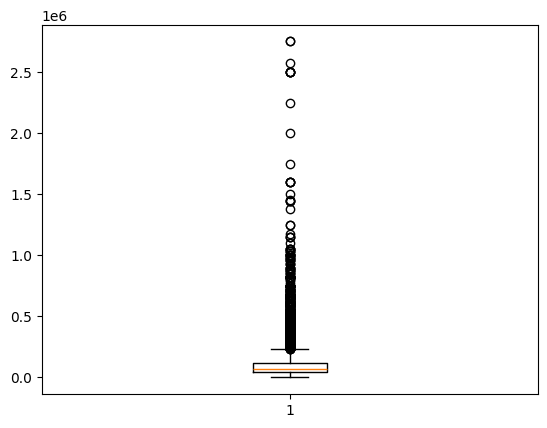

In [1157]:
import matplotlib.pyplot as plt
import numpy as np

plt.boxplot(df['mean_salary'])

{'whiskers': [<matplotlib.lines.Line2D at 0x44a2ba300>,
 'caps': [<matplotlib.lines.Line2D at 0x44a2b89b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x595480b00>],
 'medians': [<matplotlib.lines.Line2D at 0x44a2bbc50>],
 'fliers': [<matplotlib.lines.Line2D at 0x44a2b8830>],
 'means': []}

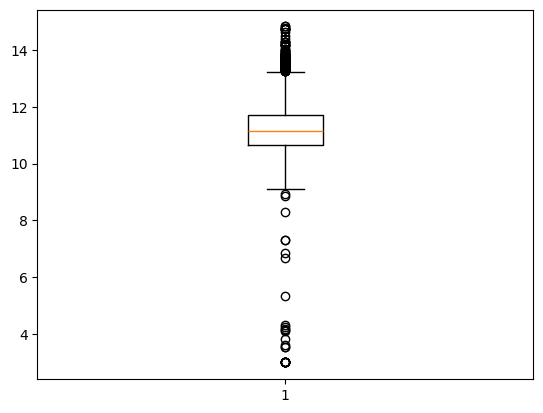

In [1158]:
plt.boxplot(df['mean_salary'].apply(lambda x: np.log(x)))

Логарифм применим позже.  
Ограничение по диапазону зарплат ухудшает результат. 

# Аналогичная обработка тестового набора данных

In [1159]:
df_pred = pd.read_csv(path + "/for_prediction.csv")

In [1160]:
%%capture
func1(df_pred)
df_pred = func2(df_pred, city_mean_salary)
func3(df_pred)
func4(df_pred)
func5(df_pred)
func6(df_pred)
func7(df_pred, schedule_categories)

In [1161]:
# Проверка, что колонки совпадают с тренировочным набором
# Добавление отсутствующих колонок
train_cols = set(df.drop('mean_salary', axis=1).columns)
test_cols = set(df_pred.drop('Id', axis=1).columns)

for col in train_cols - test_cols:
    df_pred[col] = 0
    print(col)

for col in test_cols - train_cols:
    if col != 'Id':
        df_pred.drop(col, axis=1, inplace=True)

# Упорядочивание колонок как в тренировочном наборе
train_cols_order = df.drop('mean_salary', axis=1).columns.tolist()
df_pred = df_pred[['Id'] + train_cols_order]

schedule_Вахтовый метод
schedule_Удаленная работа
schedule_Гибкий график
schedule_Сменный график
schedule_Полный день


In [1162]:
df_pred

,Id,experience,city_mean_salary,is_open,name_emb_0,name_emb_1,name_emb_2,name_emb_3,name_emb_4,name_emb_5,...,is_lead,is_senior,work_in_shifts,weekend_work,Delayed_start_of_work,schedule_Вахтовый метод,schedule_Гибкий график,schedule_Полный день,schedule_Сменный график,schedule_Удаленная работа
0,0,1,134738.590843,1,0.034244,0.078160,-0.009737,0.018762,-0.058454,0.006389,...,False,False,0,0,0,0,0,0,0,0
1,1,0,90404.228668,1,0.016195,0.056814,0.026840,-0.015345,-0.054286,0.021636,...,False,False,0,0,0,0,0,0,0,0
2,2,0,90404.228668,1,0.001676,0.054740,0.028216,-0.000011,-0.033859,-0.020591,...,False,False,0,0,0,0,0,0,0,0
3,3,2,90404.228668,1,0.009665,0.012533,-0.002277,-0.061712,-0.113764,-0.011051,...,False,False,0,0,0,0,0,0,0,0
4,4,1,134738.590843,1,0.025050,0.080505,-0.087802,0.027451,-0.065855,-0.001304,...,False,True,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7513,7513,1,68132.201058,1,-0.046323,0.133809,-0.030998,0.013514,-0.053348,0.069178,...,False,False,0,0,0,0,0,0,0,0
7514,7514,1,134738.590843,1,-0.025338,0.098874,-0.027814,0.061213,-0.006586,0.038891,...,False,True,0,0,0,0,0,0,0,0
7515,7515,0,90404.228668,1,0.017880,0.061173,-0.081873,0.043477,-0.053118,0.078479,...,False,False,0,0,0,0,0,0,0,0
7516,7516,1,68132.201058,1,-0.005541,0.017839,-0.023107,-0.008329,-0.101785,0.012020,...,False,True,0,0,0,0,0,0,0,0


## Базовая модель: линейная регрессия

In [1163]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(['mean_salary'], axis=1), df['mean_salary'], test_size=0.2, random_state=42)

In [1164]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test) 

In [1165]:
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error

base_reg = LinearRegression().fit(X_train, y_train_log)
print('MAE score: ', mean_absolute_error(y_test_log, base_reg.predict(X_test)))

MAE score:  0.3719078897561151


In [1166]:
prediction_log = base_reg.predict(df_pred.drop('Id', axis=1))
prediction = np.expm1(prediction_log) 
submission = pd.DataFrame({
    'Id': df_pred['Id'],
    'Predicted': prediction
})

submission.to_csv('submission.csv', index=False)

## XGBRegressor

In [1167]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# parameters = {
#     'n_estimators': [50, 100],
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.01, 0.1],
#     'min_child_weight': [1, 3, 5],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 1.0],
#     'gamma': [0, 0.1, 0.2]
# }

# XGBR = XGBRegressor(random_state=42)

# grid_search = GridSearchCV(
#     estimator=XGBR,
#     param_grid=parameters,
#     scoring='neg_mean_absolute_error',
#     n_jobs=-1,
#     verbose=1,
#     refit=True
# )
# grid_search.fit(X_train, y_train)

# print(f"Лучшие параметры: {grid_search.best_params_}")

In [1168]:
XGBR = XGBRegressor(random_state=42, colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100, subsample=0.8).fit(X_train, y_train_log)
print('MAE score: ', mean_absolute_error(y_test_log, XGBR.predict(X_test)))

MAE score:  0.3289982729390123


In [1169]:
prediction_log = XGBR.predict(df_pred.drop('Id', axis=1))
prediction = np.expm1(prediction_log) 
submission = pd.DataFrame({
    'Id': df_pred['Id'],
    'Predicted': prediction
})

submission.to_csv('submission_XGBR.csv', index=False)